In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from sklearn.model_selection import train_test_split

In [3]:
data, ds_info = tfds.load(
    'cifar10',
    split='train',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

I0000 00:00:1730312764.922745   64797 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-30 15:26:04.924650: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
df = tfds.as_dataframe(data.take(6000),ds_info)

2024-10-30 15:26:26.296648: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [9]:
cats_dogs = df.loc[(df.label == 3) | (df.label == 5)].reset_index()
cats_dogs = cats_dogs.drop(axis=0, columns='index')
cats_dogs.shape

(1214, 2)

In [10]:
labels = cats_dogs.label.to_numpy().astype(np.uint8)
labels

array([5, 3, 3, ..., 5, 3, 5], dtype=uint8)

In [11]:
images = cats_dogs.image.to_numpy()/255.0
images.shape

(1214,)

In [12]:
for image_i in trange(images.shape[0]):
    new_image = images[image_i]

    new_image = tf.image.convert_image_dtype(new_image, dtype=tf.float32)
    new_image = tf.image.resize(new_image, (20,20))
    new_image = tf.image.rgb_to_grayscale(new_image)

    images[image_i] = new_image

100%|██████████| 1214/1214 [00:01<00:00, 719.87it/s]


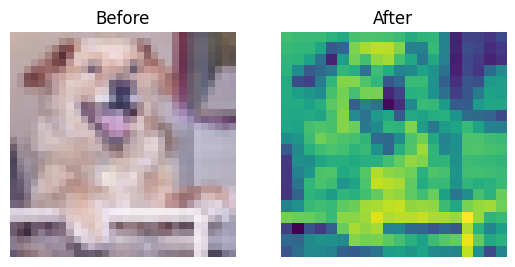

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)

ax1.imshow(cats_dogs.image[100])
ax1.set_title('Before')
ax1.axis('off')


ax2.imshow(images[100])
ax2.set_title('After')
ax2.axis('off')

plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.10, random_state=37)